In [1]:
!pip install langchain_community langchain_openai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.3/55.3 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 2.5 MB/s eta 0:00:00


In [2]:
!pip install langgraph

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.9/130.9 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.4/45.4 kB 3.3 MB/s eta 0:00:00


In [3]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated
import operator
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage
from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults

In [5]:
import os
from google.colab import userdata

os.environ['OPENAI_API_KEY'] = userdata.get('OPENAI_API_KEY')
os.environ['TAVILY_API_KEY'] = userdata.get('TAVILY_API_KEY')
os.environ['LANGCHAIN_API_KEY'] = userdata.get('LANGCHAIN_API_KEY')




In [6]:
tool = TavilySearchResults(max_results=4) #increased number of results
print(type(tool))
print(tool.name)

<class 'langchain_community.tools.tavily_search.tool.TavilySearchResults'>
tavily_search_results_json


In [7]:
class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]

#### Note: in **take_action** below, some logic was added to cover the case that the LLM returned a non-existent tool name. Even with function calling, LLMs can still occasionally hallucinate. Note that all that is done is instructing the LLM to try again! An advantage of an agentic organization.

In [8]:
class Agent:

    def __init__(self, model, tools, system=""):
        self.system = system
        graph = StateGraph(AgentState)
        graph.add_node("llm", self.call_openai)
        graph.add_node("action", self.take_action)
        graph.add_conditional_edges(
            "llm",
            self.exists_action,
            {True: "action", False: END}
        )
        graph.add_edge("action", "llm")
        graph.set_entry_point("llm")
        self.graph = graph.compile()
        self.tools = {t.name: t for t in tools}
        self.model = model.bind_tools(tools)

    def exists_action(self, state: AgentState):
        result = state['messages'][-1]
        return len(result.tool_calls) > 0

    def call_openai(self, state: AgentState):
        messages = state['messages']
        if self.system:
            messages = [SystemMessage(content=self.system)] + messages
        message = self.model.invoke(messages)
        return {'messages': [message]}

    def take_action(self, state: AgentState):
        tool_calls = state['messages'][-1].tool_calls
        results = []
        for t in tool_calls:
            print(f"Calling: {t}")
            if not t['name'] in self.tools:      # check for bad tool name from LLM
                print("\n ....bad tool name....")
                result = "bad tool name, retry"  # instruct LLM to retry if bad
            else:
                result = self.tools[t['name']].invoke(t['args'])
            results.append(ToolMessage(tool_call_id=t['id'], name=t['name'], content=str(result)))
        print("Back to the model!")
        return {'messages': results}

In [9]:
prompt = """You are a smart research assistant. Use the search engine to look up information. \
You are allowed to make multiple calls (either together or in sequence). \
Only look up information when you are sure of what you want. \
If you need to look up some information before asking a follow up question, you are allowed to do that!
"""

model = ChatOpenAI(model="gpt-4o")
abot = Agent(model, [tool], system=prompt)

In [15]:
!apt install libgraphviz-dev
!pip install pygraphviz

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libgail-common libgail18 libgtk2.0-0 libgtk2.0-bin libgtk2.0-common libgvc6-plugins-gtk
  librsvg2-common libxdot4
Suggested packages:
  gvfs
The following NEW packages will be installed:
  libgail-common libgail18 libgraphviz-dev libgtk2.0-0 libgtk2.0-bin libgtk2.0-common
  libgvc6-plugins-gtk librsvg2-common libxdot4
0 upgraded, 9 newly installed, 0 to remove and 29 not upgraded.
Need to get 2,434 kB of archives.
After this operation, 7,681 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libgtk2.0-common all 2.24.33-2ubuntu2.1 [125 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libgtk2.0-0 amd64 2.24.33-2ubuntu2.1 [2,038 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libgail18 amd64 2.24.33-2ubuntu2.1 [15.9 kB]
Get:4 http://archive.ubun

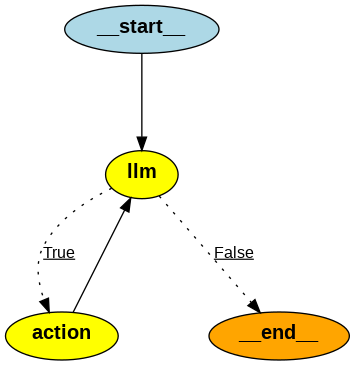

In [16]:
from IPython.display import Image
import pygraphviz

Image(abot.graph.get_graph().draw_png())

In [24]:
messages = [HumanMessage(content="Which different file system DeepSeek company used to faster inferencing of AI models explain in detailed way?")]
result = abot.graph.invoke({"messages": messages})

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'DeepSeek AI models file system for faster inferencing'}, 'id': 'call_4rcXV3GYhZlLTZfvV6HmewW6', 'type': 'tool_call'}
Back to the model!


In [25]:
result

{'messages': [HumanMessage(content='Which different file system DeepSeek company used to faster inferencing of AI models explain in detailed way?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_4rcXV3GYhZlLTZfvV6HmewW6', 'function': {'arguments': '{"query":"DeepSeek AI models file system for faster inferencing"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 28, 'prompt_tokens': 164, 'total_tokens': 192, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_f9f4fb6dbf', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-d91621c2-3aeb-47b4-a461-8429452507c2-0', tool_calls=[{'name': 'tavily_search_results_json', 'a

In [26]:
result['messages'][-1].content

'DeepSeek has developed the Fire-Flyer File System (3FS), which is a high-performance, distributed file system optimized for AI workloads. This system is specifically designed to enhance the efficiency and speed of AI model training and inference. Here’s a detailed explanation of how 3FS functions and its key features:\n\n1. **High Read Throughput**: 3FS is noted for its impressive read throughput of 6.6 TiB/s on a 180-node cluster. This facilitates rapid data access, thereby accelerating AI training and inference processes.\n\n2. **Distributed Architecture**: Being an open-source distributed file system, 3FS allows for scalability and parallel access to data, making it well-suited for large dataset handling.\n\n3. **KVCache**: For AI inference, 3FS introduces KVCache, a high-speed caching layer that enhances real-time data access. This mechanism optimizes data retrieval, reducing response times in real-time AI applications.\n\n4. **Data and Load Balancing**: Files are broken into chun

In [27]:
messages = [HumanMessage(content="How smolagents agent building framework in different from langraph and which one is best utilized in different scenarios?")]
result = abot.graph.invoke({"messages": messages})

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'smolagents agent building framework overview'}, 'id': 'call_lPkrWu73CaScwUUZhrbJpQKh', 'type': 'tool_call'}
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'langraph agent building framework overview'}, 'id': 'call_kIdBS15ge3kDaIbXS0Tu4a9l', 'type': 'tool_call'}
Back to the model!


In [28]:
result['messages'][-1].content

'Here\'s an overview of the two frameworks, SmolAgents and LangGraph, including their distinctive features and best-use scenarios:\n\n### SmolAgents\n1. **Design Philosophy**: SmolAgents, developed by Hugging Face, offers a minimalist and lightweight architecture designed for building powerful AI-driven agents with ease. It\'s known for requiring minimal code to deploy robust agents.\n   \n2. **Focus on Code Agents**: SmolAgents specializes in "code agents," which write and execute Python code snippets to perform actions. This approach is contrasted with generating actions as JSON or text blobs.\n\n3. **Tool-Calling Agents**: Besides code agents, SmolAgents also supports traditional tool-calling agents, writing actions as JSON or text blocks; this flexibility allows it to suit specific scenarios and requirements.\n\n4. **Use Cases**: SmolAgents is well-suited for scenarios where simplicity and lightweight setup are essential, and when rapid deployment of agents with minimal infrastruct

In [29]:
query = "What is the new quantum chip released by microsoft company explain its features, advantages and also how quantum computers plays crucial role in AI future advancements?"
messages = [HumanMessage(content=query)]

model = ChatOpenAI(model="gpt-4o")
abot = Agent(model, [tool], system=prompt)
result = abot.graph.invoke({"messages": messages})

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'Microsoft new quantum chip features advantages 2023'}, 'id': 'call_PoQgGCk7YpdHMIYpv6i79c1t', 'type': 'tool_call'}
Back to the model!


In [30]:
print(result['messages'][-1].content)

Microsoft recently unveiled a quantum chip named "Majorana 1," which is designed to pave the way for future advancements in quantum computing. Here are some of its features and the implications for the future, especially in artificial intelligence (AI):

### Features of the Majorana 1 Chip:
1. **Topological Core Architecture:** Majorana 1 is powered by a new Topological Core architecture that offers a path to develop quantum systems capable of scaling up to a million qubits. This architecture uses a stack of indium arsenide and aluminum materials, manipulating magnetic fields to create Majorana particles.
   
2. **Scalability:** The chip currently hosts eight qubits but is part of Microsoft’s ambition to build scalable quantum computers that can eventually solve complex industrial and societal problems in much shorter timescales.

3. **Stability and Reliability:** The chip aims to provide more stable quantum computing environments via topological qubits, which bring about more robust e

# Langraph



---

### What is LangGraph?

LangGraph is an orchestration framework within the LangChain ecosystem designed for building complex, stateful, and multi-agent AI applications. Unlike simple linear chains, LangGraph lets you design workflows as directed graphs that may include cycles (loops) and branching logic. This structure helps manage the interactions between different agents (or nodes) and external tools.

---

### Core Components

#### 1. **Nodes**

- **Definition:** Nodes are the individual units of work in a LangGraph. Each node is typically a Python function that processes input, calls a language model (LLM), or executes a tool.
- **Example Use:** A node might be a chatbot function that takes conversation history as input and generates a response using an LLM.
- **Key Point:** Nodes can be combined and reused, making it easy to design complex workflows.

#### 2. **Edges**

- **Definition:** Edges connect nodes and define the flow of information through the graph.
- **Types:**
  - **Direct Edges:** These simply link one node to another.
  - **Conditional Edges:** These include logic (like if-else statements) to decide which node to execute next based on the state.
- **Key Point:** Edges determine the overall structure of the application, whether it's linear, cyclic, or branching.

#### 3. **State**

- **Definition:** The state is a shared data object that is passed between nodes. It typically includes the conversation history (messages) and can also store other data (like user information or facts extracted from the conversation).
- **How It Works:** When a node returns an update (e.g., a new message), the state is updated—usually by appending new information to the existing state.
- **Key Point:** State management is automatic and can be persisted (checkpointed) so that the graph can resume execution or “remember” past interactions.

---

### How LangGraph Works

1. **Designing the Graph:**
   - You start by defining the state (usually as a dictionary or a Pydantic model).
   - Next, you add nodes (functions) that represent distinct tasks (e.g., calling an LLM, executing a search tool, etc.).
   - Then, you connect these nodes with edges to create the desired workflow.
   
2. **Tool Integration:**
   - Tools are external services or functions (like web search, database access, or human input) that your agent can call.
   - LangGraph allows you to bind tools to an LLM, so the model learns which JSON format to use when invoking a tool.
   
3. **Memory & Checkpointing:**
   - To enable multi-turn conversations, LangGraph can persist state through a checkpointing system.
   - This means your chatbot can “remember” previous interactions, making it capable of context-aware responses.
   - Advanced users can also integrate long-term memory solutions (like Zep) for storing and retrieving facts over many sessions.

4. **Human-in-the-loop:**
   - For tasks requiring oversight or correction, you can interrupt the graph execution (using functions like `interrupt`) to get human feedback.
   - The human input is then used to update the state, ensuring higher reliability.

5. **Time Travel:**
   - LangGraph’s checkpointing system even allows you to “rewind” to previous states. This is useful for debugging, error recovery, or exploring alternative conversation paths.

---

### Use Cases

- **Chatbots & Virtual Assistants:** Manage complex multi-turn conversations with memory and human oversight.
- **Autonomous Agents:** Build agents that can autonomously choose which tool to call based on the task.
- **Workflow Automation:** Design systems where multiple agents collaborate to execute complex business processes.

---

### Why Use LangGraph?

- **Flexibility:** Its graph-based design supports complex workflows (including loops and conditional logic) which are hard to implement with simple chains.
- **Built-in Persistence:** Automatic state checkpointing allows for context retention across sessions.
- **Tool Integration:** Easily extend functionality by incorporating external tools and APIs.
- **Human Oversight:** Supports human-in-the-loop workflows, increasing reliability and control over autonomous decisions.

---





# Understanding LangGraph

LangGraph is a library built on top of LangChain that helps developers create complex, stateful workflows for language model applications. It's essentially a framework for building stateful multi-agent systems using language models.

## Core Concepts of LangGraph

### State Machines and Graphs

At its heart, LangGraph uses the concept of a directed graph (or state machine) to organize the flow of information in an application. This approach allows you to:

1. Define distinct "states" your application can be in
2. Create explicit transitions between these states
3. Maintain memory and context throughout the execution flow

This structure is particularly valuable when you need your application to make decisions about what to do next based on previous steps and current conditions.

### Components of LangGraph

#### 1. Nodes

Nodes represent distinct processing steps in your application. Each node is a function that:
- Takes the current state as input
- Performs some computation (often involving an LLM)
- Returns an updated state

For example, a node might:
- Parse user input
- Generate a response with an LLM
- Execute a tool or API call
- Make a decision about the next step

#### 2. Edges

Edges define the possible transitions between nodes. They determine which node should execute next based on the current state.

#### 3. State

The state is a shared memory object that persists throughout the execution of your graph. It allows information to be passed between nodes and maintains the context of the conversation or task.

## Why LangGraph is Useful for Beginners

### 1. Structured Approach to Complex Applications

For beginners, one of the challenges of building LLM applications is managing the complexity of multi-step processes. LangGraph provides a clear structure for breaking down complex tasks into manageable pieces.

### 2. Visualization and Debugging

LangGraph allows you to visualize your application flow, making it easier to understand how different components interact. This visualization is invaluable for debugging and explaining your application to others.

### 3. Reusable Components

The modular nature of LangGraph allows beginners to start with simple components and gradually build up complexity. You can reuse components across different applications.

## Creating a Simple LangGraph Application

Let me show you how to create a basic LangGraph application. I'll walk through the process step by step:

```python
# Install necessary packages
!pip install langchain langchain-core langchain-community langgraph

# Import required libraries
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, AIMessage
from langgraph.graph import StateGraph
import operator
from typing import TypedDict, List, Literal

# Define the state structure
class AgentState(TypedDict):
    messages: List
    next_step: Literal["generate", "decide", "end"]

# Initialize the LLM
llm = ChatOpenAI(temperature=0)

# Define node functions
def generate(state):
    # Prompt for generating a response
    prompt = ChatPromptTemplate.from_messages([
        ("system", "You are a helpful assistant."),
        MessagesPlaceholder(variable_name="messages")
    ])
    
    # Chain the prompt with the LLM
    chain = prompt | llm
    
    # Generate response
    response = chain.invoke({"messages": state["messages"]})
    
    # Update state with the new message
    return {
        "messages": state["messages"] + [AIMessage(content=response.content)],
        "next_step": "decide"
    }

def decide(state):
    # Decide if we need more information or can end the conversation
    last_message = state["messages"][-1].content
    
    if "need more information" in last_message.lower():
        return {"next_step": "generate"}
    else:
        return {"next_step": "end"}

# Build the graph
workflow = StateGraph(AgentState)

# Add nodes
workflow.add_node("generate", generate)
workflow.add_node("decide", decide)

# Define edges
workflow.add_conditional_edges(
    "decide",
    lambda state: state["next_step"],
    {
        "generate": "generate",
        "end": END
    }
)

# Set the entry point
workflow.set_entry_point("generate")

# Compile the graph
app = workflow.compile()

# Test the application
result = app.invoke({
    "messages": [HumanMessage(content="What is LangGraph?")],
    "next_step": "generate"
})

# Print the conversation
for message in result["messages"]:
    print(f"{message.type}: {message.content}\n")
```

## Advanced LangGraph Features

### 1. Multi-Agent Systems

LangGraph excels at creating systems where multiple agents with different roles collaborate:

```python
# Define agent roles
def researcher(state):
    # Research relevant information
    # ...

def planner(state):
    # Create a plan based on research
    # ...

def executor(state):
    # Execute the plan
    # ...

# Connect them in a workflow
workflow.add_node("researcher", researcher)
workflow.add_node("planner", planner)
workflow.add_node("executor", executor)
```

### 2. Tool Use and External Integrations

LangGraph can integrate with external tools and APIs:

```python
def use_calculator(state):
    # Extract math expression from state
    expression = extract_math_expression(state["messages"])
    
    # Calculate result
    result = eval(expression)
    
    # Update state with result
    return {
        "messages": state["messages"] + [AIMessage(content=f"The result is {result}")],
        "next_step": "decide"
    }

# Add tool to graph
workflow.add_node("calculator", use_calculator)
```

### 3. Human-in-the-Loop Processes

LangGraph supports workflows where humans provide input at critical decision points:

```python
def get_human_feedback(state):
    # Display current state to human
    print("Current plan:", state["plan"])
    
    # Get feedback
    feedback = input("Your feedback: ")
    
    # Update state with feedback
    return {
        "messages": state["messages"] + [HumanMessage(content=feedback)],
        "next_step": "revise"
    }
```

## Real-World Applications of LangGraph

1. **Conversational Agents**: Build chatbots that maintain context over long conversations and can switch between different conversation modes.

2. **Research Assistants**: Create agents that can break down research tasks, search for information, synthesize findings, and present results.

3. **Workflow Automation**: Automate complex business processes that require decision-making and adaptation.

4. **Content Creation**: Build systems that plan, draft, edit, and refine content based on specific guidelines.
